# Criteo Attribution Modeling for Bidding (EDA)

## 1. Goal of the project


## 2. Overview data
This notebook analyses the data retrieved from [Kaggle](https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling/data). The dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user and if it was clicked, led to a conversion and if it was attributed to Criteo.

Columns of the dataset from [Kaggle](https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling)
- **timestamp**: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.  
- **uid**: a unique user identifier  
- **campaign**: a unique identifier for the campaign  
- **conversion 1**: if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)  
- **conversion_timestamp**: the timestamp of the conversion or -1 if no conversion was observed
conversion_id a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion  
- **attribution 1**: if the conversion was attributed to Criteo, 0 otherwise  
- **click 1**: if the impression was clicked, 0 otherwise  
- **click_pos**: the position of the click before a conversion (0 for first-click)  
- **click_nb**: number of clicks. More than 1 if there was several clicks before a conversion  
- **cost**: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)  
- **cpo**: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)  
- **time_since_last_click**: the time since the last click (in s) for the given impression  
- **cat[1-9]**: contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).  

| Column name | Description |
| --- | ----------- |
| timestamp | Timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.|
| uid | Unique user identifier|
| campaign | Unique identifier for the campaign|
| conversion 1 | If there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)|
| conversion_timestamp | The timestamp of the conversion or -1 if no conversion was observed conversion_id a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion |
| attribution 1 | If the conversion was attributed to Criteo, 0 otherwise |
| click 1 | If the impression was clicked, 0 otherwise |
| click_nb | Number of clicks. More than 1 if there was several clicks before a conversion |
| cost | The price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it) |
| cpo | The cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it) |
| time_since_last_click | The time since the last click (in s) for the given impression |
| cat[1-9] | Contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference). |

In [22]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# read in csv file and display first 5 rows of the datset
df = pd.read_csv("c:/Users/Maria/Desktop/ds_projects/attribution/data/raw/pcb_dataset_final.tsv", sep='\t')
df.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


In [4]:
# check which columns are included in our dataframe
df.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9'],
      dtype='object')

In [5]:
# Shape of the dataset
df.shape

(16468027, 22)

In [6]:
# Check out our data-types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468027 entries, 0 to 16468026
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   timestamp              int64  
 1   uid                    int64  
 2   campaign               int64  
 3   conversion             int64  
 4   conversion_timestamp   int64  
 5   conversion_id          int64  
 6   attribution            int64  
 7   click                  int64  
 8   click_pos              int64  
 9   click_nb               int64  
 10  cost                   float64
 11  cpo                    float64
 12  time_since_last_click  int64  
 13  cat1                   int64  
 14  cat2                   int64  
 15  cat3                   int64  
 16  cat4                   int64  
 17  cat5                   int64  
 18  cat6                   int64  
 19  cat7                   int64  
 20  cat8                   int64  
 21  cat9                   int64  
dtypes: float64(2), i

In [7]:
# Checking for missing values
df.isnull().sum()

timestamp                0
uid                      0
campaign                 0
conversion               0
conversion_timestamp     0
conversion_id            0
attribution              0
click                    0
click_pos                0
click_nb                 0
cost                     0
cpo                      0
time_since_last_click    0
cat1                     0
cat2                     0
cat3                     0
cat4                     0
cat5                     0
cat6                     0
cat7                     0
cat8                     0
cat9                     0
dtype: int64

In [10]:
# Checking the number of unique user ids in the whole dataset:
unique_uids=df['uid'].unique()
print(f"There are {len(unique_uids)} unique user ids in the dataset.")

There are 6142256 unique user ids in the dataset.


In order to be able to attribute the conversion success, we focus on those customer journeys which resulted in a conversion.

In [10]:
df_conversions = df[df['conversion']==1].copy()

For the modeling, it is important to have at least two contacts in order to evaluate different attribution models. So, we analyze the data with regards to the chain length within the customer journey that led to a conversion.

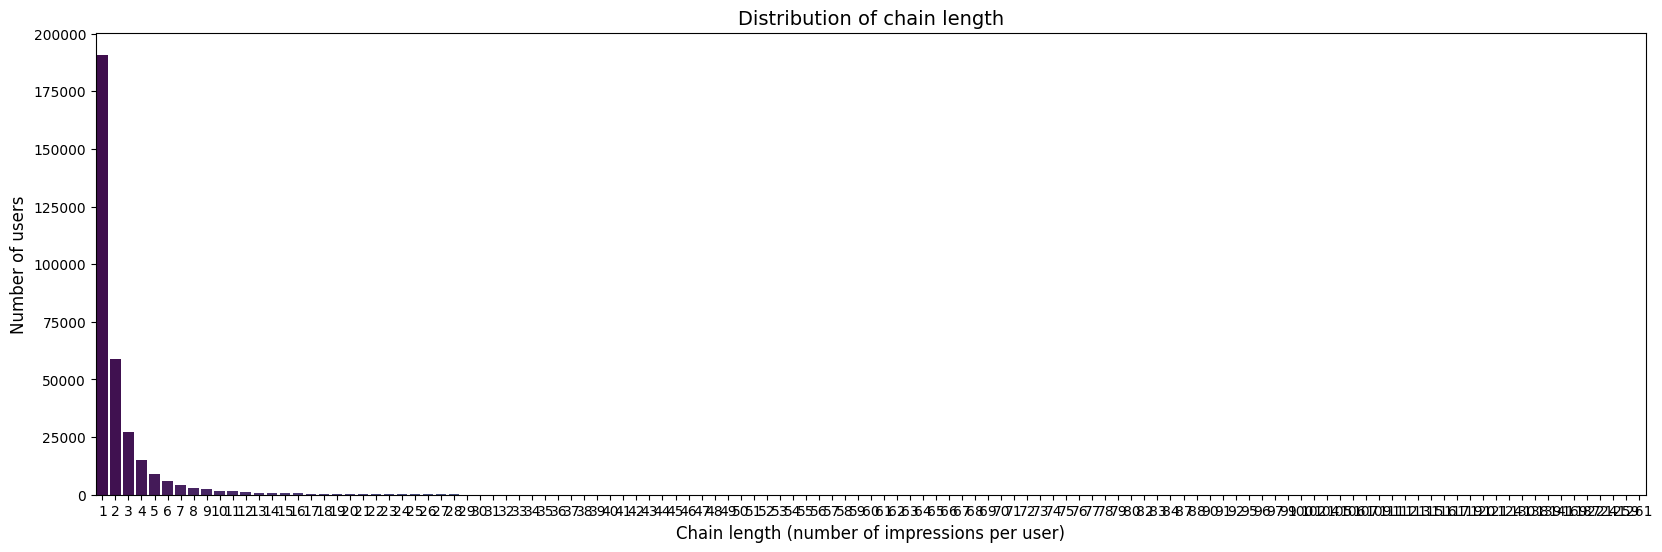

In [31]:
chain_lengths = df_conversions['uid'].value_counts()
length_distribution = chain_lengths.value_counts().sort_index()

plt.figure(figsize=(20,6))
sns.barplot(x = length_distribution.index, y = length_distribution.values, palette="viridis")

plt.title("Distribution of chain length", fontsize = 14)
plt.xlabel("Chain length (number of impressions per user)", fontsize = 12)
plt.ylabel("Number of users", fontsize = 12)

plt.show()

The graph shows, that most of the chains have only one contact, so we are reducing the dataset to those customer journeys which had a conversion and at least two impressions in the chain.

## 3. Creating a subset of the dataset

In [15]:
# Creating a subset of the dataframe with these users
valid_uids = chain_lengths[chain_lengths >= 2].index
df_subset = df_conversions[df_conversions['uid'].isin(valid_uids)].copy()

# Dropping the category columns
df_subset.drop(["cat1","cat2", "cat3", "cat4", "cat5", "cat6", "cat7", "cat8", "cat9"], axis=1, inplace=True)

In [16]:
df_subset.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,0.000094,0.154785,-1
25,17,15394453,9100693,1,154,24795488,1,1,0,1,0.001435,0.004617,583864
44,25,6013772,15184511,1,138469,15587012,0,1,1,6,0.001585,0.005025,536
52,30,9451380,17321082,1,355909,4136014,0,1,1,3,0.000413,0.324492,363648
166,93,2380977,32368244,1,1471679,28647208,0,1,5,8,0.001034,0.019889,145936


In [18]:
df_subset.shape

(615305, 13)

In [19]:
df_subset.describe()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click
count,6.153050e+05,6.153050e+05,6.153050e+05,615305.0,6.153050e+05,6.153050e+05,615305.000000,615305.0,615305.000000,615305.000000,615305.000000,615305.000000,6.153050e+05
mean,1.329446e+06,1.620724e+07,1.729770e+07,1.0,1.964925e+06,1.621269e+07,0.565971,1.0,3.165110,7.326921,0.001195,0.108924,2.674005e+05
std,7.575506e+05,9.367422e+06,9.580193e+06,0.0,1.022225e+06,9.341587e+06,0.495629,0.0,6.759645,11.241195,0.002398,0.098341,4.371725e+05
min,3.000000e+00,6.560000e+02,7.332200e+04,1.0,1.540000e+02,1.980000e+02,0.000000,1.0,0.000000,1.000000,0.000010,0.004000,-1.000000e+00
25%,6.697400e+05,8.063225e+06,9.100693e+06,1.0,1.187478e+06,8.155253e+06,0.000000,1.0,0.000000,2.000000,0.000164,0.020761,5.170000e+02
50%,1.330724e+06,1.620867e+07,1.518451e+07,1.0,1.935696e+06,1.620644e+07,1.000000,1.0,1.000000,4.000000,0.000450,0.083530,8.287800e+04
75%,1.955258e+06,2.429762e+07,2.749144e+07,1.0,2.627995e+06,2.426364e+07,1.000000,1.0,3.000000,8.000000,0.001191,0.173787,3.380890e+05
max,2.671187e+06,3.245859e+07,3.245211e+07,1.0,5.251122e+06,3.245852e+07,1.000000,1.0,173.000000,174.000000,0.057756,0.998048,2.591880e+06


## 4. Segmentation of the chain length

In [28]:
chain_lengths = df_subset['uid'].value_counts()
chain_segments = pd.cut(chain_lengths, bins=[3, 10, 25, 100, np.inf], labels=["short (2-3)", "medium (4-10)", "long (11-25)", "xl (25+)"])
df_subset['chain_segment'] = df_subset['uid'].map(chain_segments)

c:\Users\Maria\Desktop\ds_projects\attribution\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


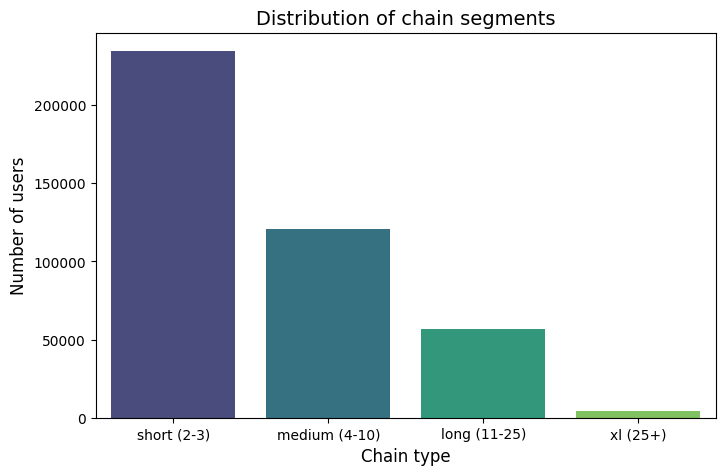

In [29]:
# Häufigkeit je Kettensegment
segment_counts = df_subset['chain_segment'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")

plt.title("Distribution of chain segments", fontsize=14)
plt.xlabel("Chain type", fontsize=12)
plt.ylabel("Number of users", fontsize=12)
plt.show()

## 5. Making sure, that the considered contacts in the customer journey are before the conversion

In [38]:
# Highest conversion timestamp per user
conversion_times = df_subset.groupby('uid')['conversion_timestamp'].max()

# Creating a copy of the data subset
df_subset_check_ts = df_subset.copy()

# Mapping to the whole subset
df_subset_check_ts['max_conversion_ts'] = df_subset_check_ts['uid'].map(conversion_times)

# Flagging if conversion after the contact
df_subset_check_ts['after_conversion'] = df_subset_check_ts['timestamp'] > df_subset_check_ts['max_conversion_ts']

In [40]:
df_subset_check_ts['after_conversion'].value_counts()

after_conversion
False    615305
Name: count, dtype: int64

Conclusion: All contacts are before the respective conversions, so no need to exclude contacts from the data.

## 5. Saving the subset of the data as csv

In [20]:
df_subset.to_csv('c:/Users/Maria/Desktop/ds_projects/attribution/data/processed/pcb_subset.csv', index=False)